# Baseline Models

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score


In [4]:
data = pd.read_csv('./data/data.csv')
data

,cik,sic,sic_description,filedate,accession_num,primary_doc,filelink,bank_status,Assets,AssetsCurrent,...,debt_to_total_assets,return_on_assets,return_on_equity,ebit_over_assets,current_assets_over_assets,cash_over_assets,cash_operation_over_assets,cash_operation_over_liabilities,main_industry,year
0,1606180,8093.0,"Services-Specialty Outpatient Facilities, NEC",2019-04-15,0001564590-19-011552,aac-10k_20181231.htm,https://www.sec.gov/Archives/edgar/data/160618...,1,452277000,63964000,...,0.906533,-0.131344,-0.922236,-0.082998,0.141427,0.011959,-0.063797,-0.070375,Services,2019
1,2034,5122.0,"Wholesale-Drugs, Proprietaries & Druggists' Su...",2018-09-28,0001144204-18-051414,tv501271_10k.htm,https://www.sec.gov/Archives/edgar/data/2034/0...,1,767024000,502627000,...,0.875773,-0.045274,-0.364444,-0.358544,0.655295,0.131513,0.132729,0.151556,Wholesale Trade,2018
2,3116,2834.0,Pharmaceutical Preparations,2020-02-26,0001628280-20-002314,akorn10k12312019.htm,https://www.sec.gov/Archives/edgar/data/3116/0...,1,1288639000,480047000,...,0.818186,-0.062593,-0.344271,-0.034129,0.372522,0.112370,-0.028650,-0.035016,Manufacturing,2020
3,1376610,1040.0,Gold and Silver Ores,2015-03-27,0001376610-15-000004,anv-2014123110xk.htm,https://www.sec.gov/Archives/edgar/data/137661...,1,941238000,298847000,...,0.705114,-0.490013,-1.661703,-0.510096,0.317504,0.008048,0.000884,0.001254,Mining,2015
4,1405073,1311.0,Crude Petroleum & Natural Gas,2019-03-18,0001564590-19-008275,arex-10k_20181231.htm,https://www.sec.gov/Archives/edgar/data/140507...,1,1084647000,16225000,...,0.456740,0.000800,0.001473,0.001115,0.014959,0.000020,0.032033,0.070133,Mining,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12840,1403568,5990.0,"Retail-Retail Stores, NEC",2020-03-27,0001558370-20-003272,ulta-20200201x10k11b4b7.htm,https://www.sec.gov/Archives/edgar/data/140356...,0,4863872000,2055317000,...,0.608934,0.045790,0.117091,0.059162,0.422568,0.080661,0.226423,0.371835,Retail Trade,2020
12841,1403568,5990.0,"Retail-Retail Stores, NEC",2019-04-02,0001558370-19-002739,ulta-20190202x10k.htm,https://www.sec.gov/Archives/edgar/data/140356...,0,3191172000,1914861000,...,0.429608,0.067271,0.117939,0.088121,0.600049,0.128245,0.299616,0.697417,Retail Trade,2019
12842,1403568,5990.0,"Retail-Retail Stores, NEC",2018-04-03,0001558370-18-002733,ulta-20180203x10k.htm,https://www.sec.gov/Archives/edgar/data/140356...,0,2908687000,1693743000,...,0.390028,0.071569,0.117332,0.087469,0.582305,0.095385,0.267944,0.686987,Retail Trade,2018
12843,1403568,5990.0,"Retail-Retail Stores, NEC",2013-04-03,0001193125-13-140116,d466694d10k.htm,https://www.sec.gov/Archives/edgar/data/140356...,0,1275249000,789324000,...,0.382911,0.050603,0.082004,0.081369,0.618957,0.251304,0.187415,0.489448,Retail Trade,2013


In [5]:
# Drop irrelevant columns
y = data['bank_status']
X = data.drop(columns = ['cik', 'sic', 'sic_description', 'filedate', 'accession_num',
       'primary_doc', 'filelink', 'bank_status'])

In [6]:
# Create dummy variables for industry and year
X_with_dummies = pd.get_dummies(X, columns = ['main_industry', 'year'])
X_with_dummies

,Assets,AssetsCurrent,Liabilities,LiabilitiesCurrent,StockholdersEquity,CashAndCashEquivalentsAtCarryingValue,NetCashProvidedByUsedInOperatingActivities,NetCashProvidedByUsedInFinancingActivities,NetCashProvidedByUsedInInvestingActivities,NetIncomeLoss,...,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024
0,452277000,63964000,410004000,361445000,64413000,5409000.0,-28854000,105221000,-84776000,-59404000,...,False,False,False,False,True,False,False,False,False,False
1,767024000,502627000,671739000,302518000,95285000,100874000.0,101806000,-48863000,-8281000,-34726000,...,False,False,False,True,False,False,False,False,False,False
2,1288639000,480047000,1054347000,985587000,234292000,144804000.0,-36919000,-12928000,-30402000,-80660000,...,False,False,False,False,False,True,False,False,False,False
3,941238000,298847000,663680000,592376000,277558000,7575000.0,832000,-8853000,-65874000,-461219000,...,True,False,False,False,False,False,False,False,False,False
4,1084647000,16225000,495402000,21077000,589245000,22000.0,34744000,8021000,-42764000,868000,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12840,4863872000,2055317000,2961778000,1137261000,1902094000,392325000.0,1101293000,-646739000,-471480000,222719000,...,False,False,False,False,False,True,False,False,False,False
12841,3191172000,1914861000,1370954000,823736000,1820218000,409251000.0,956127000,-609214000,-215107000,214674000,...,False,False,False,False,True,False,False,False,False,False
12842,2908687000,1693743000,1134470000,642166000,1774217000,277445000.0,779366000,-356217000,-530714000,208173000,...,False,False,False,True,False,False,False,False,False,False
12843,1275249000,789324000,488307000,221067000,786942000,320475000.0,239001000,16314000,-188578000,64532000,...,False,False,False,False,False,False,False,False,False,False


In [7]:
# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_with_dummies, y, test_size = 0.25, random_state = 42)

In [8]:
# Standardization
scaler = StandardScaler().fit(X_train.iloc[:, 0:23])
scaled_terms_train = pd.DataFrame(scaler.transform(X_train.iloc[:, 0:23]), columns = X_train.columns[0:23])
X_train_scaled = pd.concat([scaled_terms_train, X_train.iloc[:,23:].reset_index(drop = True)], axis = 1)
scaled_terms_test = pd.DataFrame(scaler.transform(X_test.iloc[:, 0:23]), columns = X_test.columns[0:23])
X_test_scaled = pd.concat([scaled_terms_test, X_test.iloc[:,23:].reset_index(drop = True)], axis = 1)

## Balance dataset

In [39]:
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

## Adaptive Synthetic Sampling (ADASYN) + Decision Tree

In [59]:
model = DecisionTreeClassifier(random_state = 42)
under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42) # minority / majority = 0.9
over = ADASYN(sampling_strategy = 0.5, random_state = 42) # minority / majority = 0.5
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps = steps)

parameters = {
    'model__max_depth': [10, 15, 20, 25, 30], 
    'model__min_samples_leaf': [40, 50, 60, 70, 80], 
    'model__max_features': ['sqrt', 'log2'], 
    'model__ccp_alpha': [0.01, 0.001, 0.0001, 0.00001, 0.000001]
}
grid_search = GridSearchCV(
            pipeline,
            param_grid = parameters,
            scoring = 'average_precision',
            cv = 5)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

grid_search.fit(X_train_scaled, y_train)

Best parameters: {'model__ccp_alpha': 1e-05, 'model__max_depth': 15, 'model__max_features': 'log2', 'model__min_samples_leaf': 60}
Best score: 0.14697443932058732


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('over',
                                        ADASYN(random_state=42,
                                               sampling_strategy=0.5)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.9)),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'model__ccp_alpha': [0.01, 0.001, 0.0001, 1e-05,
                                              1e-06],
                         'model__max_depth': [10, 15, 20, 25, 30],
                         'model__max_features': ['sqrt', 'log2'],
                         'model__min_samples_leaf': [40, 50, 60, 70, 80]},
             scoring='average_precision')

In [60]:
clf = grid_search.fit(X_train_scaled, y_train)
clf.fit(X_train_scaled, y_train)
y_pred_test = clf.predict(X_test_scaled)
y_pred_prob_test = clf.predict_proba(X_test_scaled)[:,1]
y_pred_train = clf.predict(X_train_scaled)
y_pred_prob_train = clf.predict_proba(X_train_scaled)[:,1]

print(classification_report(y_train, y_pred_train))
print("Train Auc_roc:", roc_auc_score(y_train, y_pred_prob_train))
print("Train average precision:", average_precision_score(y_train, y_pred_prob_train))

print(classification_report(y_test, y_pred_test))
print("Test auc_roc:", roc_auc_score(y_test, y_pred_prob_test))
print("Test average precision:", average_precision_score(y_test, y_pred_prob_test))


              precision    recall  f1-score   support

           0       1.00      0.96      0.98      9587
           1       0.08      0.83      0.15        46

    accuracy                           0.95      9633
   macro avg       0.54      0.89      0.56      9633
weighted avg       0.99      0.95      0.97      9633

Train Auc_roc: 0.97119967709897
Train average precision: 0.22749039185140155
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      3186
           1       0.09      0.58      0.16        26

    accuracy                           0.95      3212
   macro avg       0.54      0.77      0.57      3212
weighted avg       0.99      0.95      0.97      3212

Test auc_roc: 0.9369959920807379
Test average precision: 0.11857430786589783


## SMOTE + Decision Tree

In [40]:
model = DecisionTreeClassifier(random_state = 42)
under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42)
over = SMOTE(sampling_strategy = 0.5, random_state = 42)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps = steps)

parameters = {
    'model__max_depth': [5, 10, 15, 20, 25, 30], 
    'model__min_samples_leaf': [40, 50, 60, 70, 80], 
    'model__max_features': ['sqrt', 'log2'], 
    'model__ccp_alpha': [0.01, 0.001, 0.0001, 0.00001, 0.000001]
}
grid_search = GridSearchCV(
            pipeline,
            param_grid = parameters,
            scoring = 'average_precision',
            cv = 5)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

grid_search.fit(X_train_scaled, y_train)

Best parameters: {'model__ccp_alpha': 1e-05, 'model__max_depth': 10, 'model__max_features': 'log2', 'model__min_samples_leaf': 50}
Best score: 0.10684436549915599


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.5)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.9)),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'model__ccp_alpha': [0.01, 0.001, 0.0001, 1e-05,
                                              1e-06],
                         'model__max_depth': [5, 10, 15, 20, 25, 30],
                         'model__max_features': ['sqrt', 'log2'],
                         'model__min_samples_leaf': [40, 50, 60, 70, 80]},
             scoring='average_precision')

In [41]:
clf = grid_search.fit(X_train_scaled, y_train)
clf.fit(X_train_scaled, y_train)
y_pred_test = clf.predict(X_test_scaled)
y_pred_prob_test = clf.predict_proba(X_test_scaled)[:,1]
y_pred_train = clf.predict(X_train_scaled)
y_pred_prob_train = clf.predict_proba(X_train_scaled)[:,1]

print(classification_report(y_train, y_pred_train))
print("Train Auc_roc:", roc_auc_score(y_train, y_pred_prob_train))
print("Train average precision:", average_precision_score(y_train, y_pred_prob_train))

print(classification_report(y_test, y_pred_test))
print("Test auc_roc:", roc_auc_score(y_test, y_pred_prob_test))
print("Test average precision:", average_precision_score(y_test, y_pred_prob_test))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      9587
           1       0.06      0.87      0.11        46

    accuracy                           0.93      9633
   macro avg       0.53      0.90      0.54      9633
weighted avg       0.99      0.93      0.96      9633

Train Auc_roc: 0.9718992204116987
Train average precision: 0.19833537188387634
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      3186
           1       0.08      0.81      0.15        26

    accuracy                           0.92      3212
   macro avg       0.54      0.87      0.55      3212
weighted avg       0.99      0.92      0.95      3212

Test auc_roc: 0.9271089864310204
Test average precision: 0.177545783076817


In [57]:
import matplotlib.pyplot as plt
clf = DecisionTreeClassifier(max_depth = 10, max_features = 'log2', min_samples_leaf = 50, ccp_alpha = 0.00001, random_state = 42)
under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42)
over = SMOTE(sampling_strategy = 0.5, random_state = 42)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps = steps)
x, y = pipeline.fit_resample(X_train_scaled, y_train)
clf.fit(x, y)

y_pred_test = clf.predict(X_test_scaled)
y_pred_prob_test = clf.predict_proba(X_test_scaled)[:,1]
y_pred_train = clf.predict(X_train_scaled)
y_pred_prob_train = clf.predict_proba(X_train_scaled)[:,1]

print(classification_report(y_train, y_pred_train))
print("Train Auc_roc:", roc_auc_score(y_train, y_pred_prob_train))
print("Train average precision:", average_precision_score(y_train, y_pred_prob_train))

print(classification_report(y_test, y_pred_test))
print("Test auc_roc:", roc_auc_score(y_test, y_pred_prob_test))
print("Test average precision:", average_precision_score(y_test, y_pred_prob_test))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      9587
           1       0.06      0.87      0.11        46

    accuracy                           0.93      9633
   macro avg       0.53      0.90      0.54      9633
weighted avg       0.99      0.93      0.96      9633

Train Auc_roc: 0.9718992204116987
Train average precision: 0.19833537188387634
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      3186
           1       0.08      0.81      0.15        26

    accuracy                           0.92      3212
   macro avg       0.54      0.87      0.55      3212
weighted avg       0.99      0.92      0.95      3212

Test auc_roc: 0.9271089864310204
Test average precision: 0.177545783076817


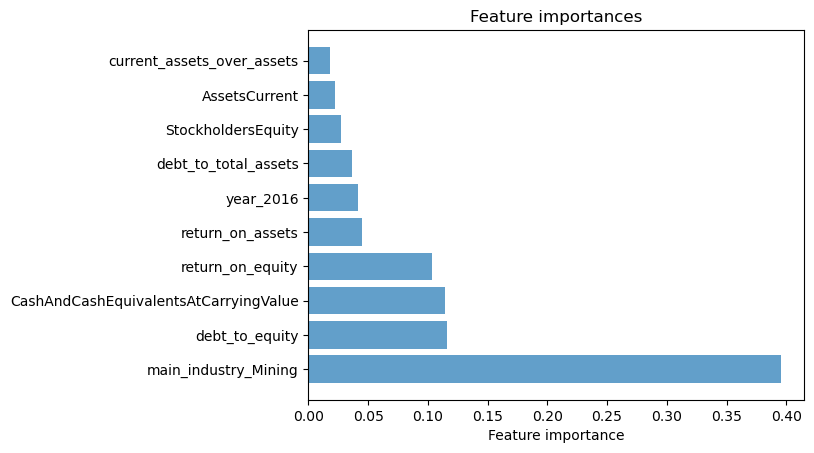

In [68]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1][:10]
plt.barh(range(len(indices)), importances[indices], alpha = 0.7)
plt.yticks(range(len(indices)), x.columns[indices])
plt.xlabel("Feature importance")
plt.show()

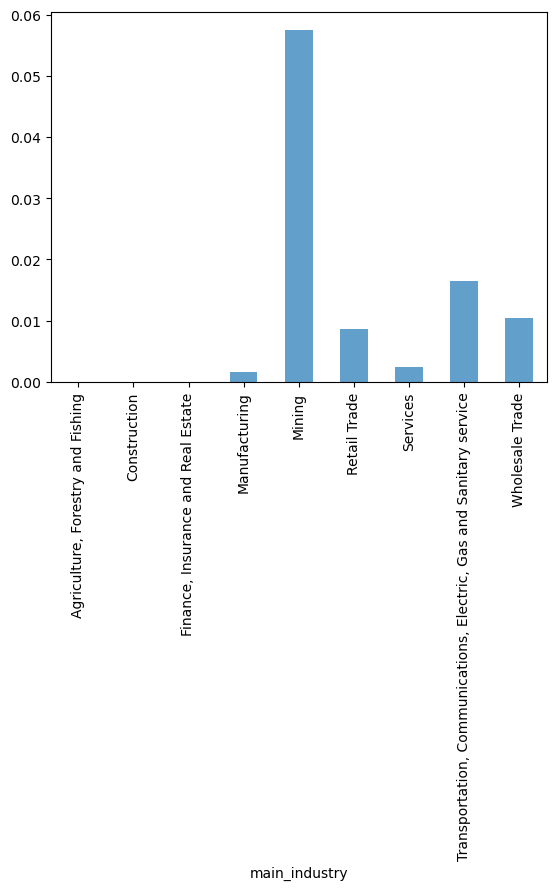

In [91]:
# Mining industry has the highest bankruptcy ratio
num_bank = data.groupby('main_industry')['bank_status'].apply(lambda x: (x == 1).sum())
num_nonbank = data.groupby('main_industry')['bank_status'].apply(lambda x: (x == 0).sum())
ratio = num_bank / num_nonbank
ratio.plot(kind = "bar", alpha = 0.7)
plt.xticks(rotation = 90)
plt.show()

## Borderline SMOTE + Decision Tree

In [66]:
model = DecisionTreeClassifier(random_state = 42)
under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42)
over = BorderlineSMOTE(sampling_strategy = 0.5, random_state = 42)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps = steps)

parameters = {
    'model__max_depth': [5, 10, 15, 20, 25, 30], 
    'model__min_samples_leaf': [40, 50, 60, 70, 80], 
    'model__max_features': ['sqrt', 'log2'], 
    'model__ccp_alpha': [0.000001, 0.0000001, 0.00000001]
}
grid_search = GridSearchCV(
            pipeline,
            param_grid = parameters,
            scoring = 'average_precision',
            cv = 5)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

grid_search.fit(X_train_scaled, y_train)

Best parameters: {'model__ccp_alpha': 1e-06, 'model__max_depth': 10, 'model__max_features': 'log2', 'model__min_samples_leaf': 60}
Best score: 0.07951031510889739


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('over',
                                        BorderlineSMOTE(random_state=42,
                                                        sampling_strategy=0.5)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.9)),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'model__ccp_alpha': [1e-06, 1e-07, 1e-08],
                         'model__max_depth': [5, 10, 15, 20, 25, 30],
                         'model__max_features': ['sqrt', 'log2'],
                         'model__min_samples_leaf': [40, 50, 60, 70, 80]},
             scoring='average_precision')

In [67]:
clf = grid_search.fit(X_train_scaled, y_train)
clf.fit(X_train_scaled, y_train)
y_pred_test = clf.predict(X_test_scaled)
y_pred_prob_test = clf.predict_proba(X_test_scaled)[:,1]
y_pred_train = clf.predict(X_train_scaled)
y_pred_prob_train = clf.predict_proba(X_train_scaled)[:,1]

print(classification_report(y_train, y_pred_train))
print("Train Auc_roc:", roc_auc_score(y_train, y_pred_prob_train))
print("Train average precision:", average_precision_score(y_train, y_pred_prob_train))

print(classification_report(y_test, y_pred_test))
print("Test auc_roc:", roc_auc_score(y_test, y_pred_prob_test))
print("Test average precision:", average_precision_score(y_test, y_pred_prob_test))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      9587
           1       0.04      0.65      0.08        46

    accuracy                           0.93      9633
   macro avg       0.52      0.79      0.52      9633
weighted avg       0.99      0.93      0.96      9633

Train Auc_roc: 0.9235831130017551
Train average precision: 0.07855257411269884
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      3186
           1       0.05      0.46      0.10        26

    accuracy                           0.93      3212
   macro avg       0.52      0.70      0.53      3212
weighted avg       0.99      0.93      0.96      3212

Test auc_roc: 0.8151950842628809
Test average precision: 0.055352951557329624


## SMOTE + Logistic Regression

In [73]:
model = LogisticRegression(max_iter = 1000, fit_intercept = False)
under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42)
over = SMOTE(sampling_strategy = 0.5, random_state = 42)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps = steps)
pipeline.fit(X_train_scaled, y_train)

Pipeline(steps=[('over', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.9)),
                ('model',
                 LogisticRegression(fit_intercept=False, max_iter=1000))])

In [83]:
y_pred_prob_test = pipeline.predict_proba(X_test_scaled)[:,1]
y_pred_test = y_pred_prob_test >= 0.5

y_pred_prob_train = pipeline.predict_proba(X_train_scaled)[:,1]
y_pred_train = y_pred_prob_train >= 0.5

print(classification_report(y_train, y_pred_train))
print("Train auc_roc:", roc_auc_score(y_train, y_pred_prob_train))
print("Train average precision:", average_precision_score(y_train, y_pred_prob_train))

print(classification_report(y_test, y_pred_test))
print("Test auc_roc:", roc_auc_score(y_test, y_pred_prob_test))
print("Test average precision:", average_precision_score(y_test, y_pred_prob_test))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      9587
           1       0.02      0.83      0.05        46

    accuracy                           0.84      9633
   macro avg       0.51      0.83      0.48      9633
weighted avg       0.99      0.84      0.91      9633

Train auc_roc: 0.913349599321545
Train average precision: 0.039931866095125154
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      3186
           1       0.04      0.81      0.07        26

    accuracy                           0.83      3212
   macro avg       0.52      0.82      0.49      3212
weighted avg       0.99      0.83      0.90      3212

Test auc_roc: 0.9262216910521995
Test average precision: 0.12074872941461902


## Borderline SMOTE + Logistic Regression

In [84]:
model = LogisticRegression(max_iter = 1000, fit_intercept = False)
under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42)
over = BorderlineSMOTE(sampling_strategy = 0.5, random_state = 42)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps = steps)
pipeline.fit(X_train_scaled, y_train)

Pipeline(steps=[('over',
                 BorderlineSMOTE(random_state=42, sampling_strategy=0.5)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.9)),
                ('model',
                 LogisticRegression(fit_intercept=False, max_iter=1000))])

In [90]:
y_pred_prob_test = pipeline.predict_proba(X_test_scaled)[:,1]
y_pred_test = y_pred_prob_test >= 0.3

y_pred_prob_train = pipeline.predict_proba(X_train_scaled)[:,1]
y_pred_train = y_pred_prob_train >= 0.3

print(classification_report(y_train, y_pred_train))
print("Train auc_roc:", roc_auc_score(y_train, y_pred_prob_train))
print("Train average precision:", average_precision_score(y_train, y_pred_prob_train))

print(classification_report(y_test, y_pred_test))
print("Test auc_roc:", roc_auc_score(y_test, y_pred_prob_test))
print("Test average precision:", average_precision_score(y_test, y_pred_prob_test))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      9587
           1       0.03      0.70      0.06        46

    accuracy                           0.89      9633
   macro avg       0.51      0.80      0.50      9633
weighted avg       0.99      0.89      0.94      9633

Train auc_roc: 0.8302275273128013
Train average precision: 0.040292333539236495
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      3186
           1       0.04      0.58      0.08        26

    accuracy                           0.89      3212
   macro avg       0.52      0.73      0.51      3212
weighted avg       0.99      0.89      0.93      3212

Test auc_roc: 0.8376249456757932
Test average precision: 0.049984837995833205


## Adaptive Synthetic Sampling (ADASYN) + Decision Tree

In [91]:
model = LogisticRegression(max_iter = 1000, fit_intercept = False)
under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42)
over = ADASYN(sampling_strategy = 0.5, random_state = 42)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps = steps)
pipeline.fit(X_train_scaled, y_train)

Pipeline(steps=[('over', ADASYN(random_state=42, sampling_strategy=0.5)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.9)),
                ('model',
                 LogisticRegression(fit_intercept=False, max_iter=1000))])

In [96]:
y_pred_prob_test = pipeline.predict_proba(X_test_scaled)[:,1]
y_pred_test = y_pred_prob_test >= 0.5

y_pred_prob_train = pipeline.predict_proba(X_train_scaled)[:,1]
y_pred_train = y_pred_prob_train >= 0.5

print(classification_report(y_train, y_pred_train))
print("Train auc_roc:", roc_auc_score(y_train, y_pred_prob_train))
print("Train average precision:", average_precision_score(y_train, y_pred_prob_train))

print(classification_report(y_test, y_pred_test))
print("Test auc_roc:", roc_auc_score(y_test, y_pred_prob_test))
print("Test average precision:", average_precision_score(y_test, y_pred_prob_test))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      9587
           1       0.02      0.85      0.05        46

    accuracy                           0.84      9633
   macro avg       0.51      0.84      0.48      9633
weighted avg       0.99      0.84      0.91      9633

Train auc_roc: 0.9140978952476406
Train average precision: 0.039325475593471
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      3186
           1       0.04      0.81      0.07        26

    accuracy                           0.83      3212
   macro avg       0.52      0.82      0.49      3212
weighted avg       0.99      0.83      0.90      3212

Test auc_roc: 0.9268977256265392
Test average precision: 0.11589063850219955


## SMOTE + SVM

In [98]:
model = SVC(random_state = 42)
under = RandomUnderSampler(sampling_strategy = 0.9, random_state = 42)
over = SMOTE(sampling_strategy = 0.5, random_state = 42)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps = steps)

parameters = {
    'model__C': [10, 100, 1000, 10000],
    'model__gamma': ['scale', 'auto'],
    'model__kernel': ['linear', 'poly', 'rbf'] 
}
grid_search = GridSearchCV(
            pipeline,
            param_grid = parameters,
            scoring = 'average_precision',
            cv = 5)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'model__C': 100, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best score: 0.09659883065609995


In [100]:
clf = grid_search.fit(X_train_scaled, y_train)
clf.fit(X_train_scaled, y_train)
y_pred_test = clf.predict(X_test_scaled)
# y_pred_prob_test = clf.predict_proba(X_test_scaled)[:,1]
y_pred_train = clf.predict(X_train_scaled)
# y_pred_prob_train = clf.predict_proba(X_train_scaled)[:,1]

print(classification_report(y_train, y_pred_train))
# print("Train Auc_roc:", roc_auc_score(y_train, y_pred_prob_train))
# print("Train average precision:", average_precision_score(y_train, y_pred_prob_train))

print(classification_report(y_test, y_pred_test))
# print("Test auc_roc:", roc_auc_score(y_test, y_pred_prob_test))
# print("Test average precision:", average_precision_score(y_test, y_pred_prob_test))

## Logistic Regression

In [37]:
x = X_train_scaled.iloc[:, 10:].drop(columns = ['cash_operation_over_assets'])
model = LogisticRegression(max_iter = 1000, fit_intercept = False)
model.fit(x, y_train)

y_pred_prob_test = model.predict_proba(X_test_scaled.iloc[:,10:].drop(columns = ['cash_operation_over_assets']))[:,1]
y_pred_test = y_pred_prob_test >= 0.01

y_pred_prob_train = model.predict_proba(x)[:,1]
y_pred_train = y_pred_prob_train >= 0.01

print(classification_report(y_train, y_pred_train))
print("Train auc_roc:", roc_auc_score(y_train, y_pred_prob_train))
print("Train average precision:", average_precision_score(y_train, y_pred_prob_train))

print(classification_report(y_test, y_pred_test))
print("Test auc_roc:", roc_auc_score(y_test, y_pred_prob_test))
print("Test average precision:", average_precision_score(y_test, y_pred_prob_test))


              precision    recall  f1-score   support

           0       1.00      0.83      0.91      9587
           1       0.02      0.74      0.04        46

    accuracy                           0.83      9633
   macro avg       0.51      0.79      0.47      9633
weighted avg       0.99      0.83      0.90      9633

Train auc_roc: 0.8580958816513303
Train average precision: 0.05860324232119395
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      3186
           1       0.03      0.77      0.07        26

    accuracy                           0.82      3212
   macro avg       0.52      0.80      0.48      3212
weighted avg       0.99      0.82      0.89      3212

Test auc_roc: 0.8926251871167126
Test average precision: 0.08255003181047406


<Axes: >

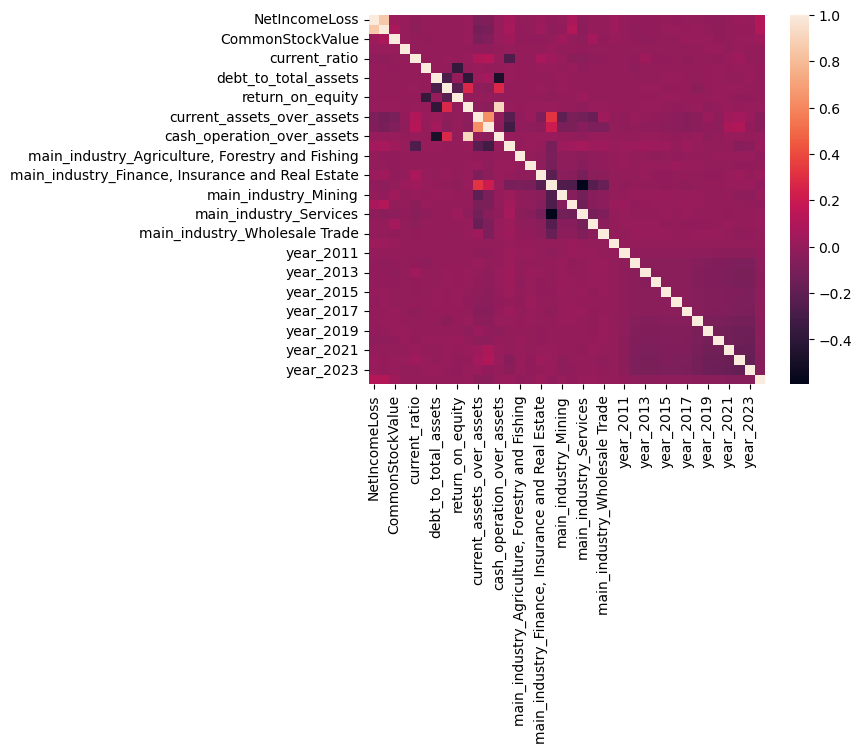

In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
X_train_scaled.corr()
sns.heatmap(X_train_scaled.iloc[:,9:].corr())


In [11]:
model = LogisticRegression(max_iter = 1000, fit_intercept = False)
model.fit(X_train_scaled, y_train)

y_pred_prob_test = model.predict_proba(X_test_scaled)[:,1]
y_pred_test = y_pred_prob_test >= 0.01

y_pred_prob_train = model.predict_proba(X_train_scaled)[:,1]
y_pred_train = y_pred_prob_train >= 0.01

print(classification_report(y_train, y_pred_train))
print("Train auc_roc:", roc_auc_score(y_train, y_pred_prob_train))
print("Train average precision:", average_precision_score(y_train, y_pred_prob_train))

print(classification_report(y_test, y_pred_test))
print("Test auc_roc:", roc_auc_score(y_test, y_pred_prob_test))
print("Test average precision:", average_precision_score(y_test, y_pred_prob_test))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91      9587
           1       0.02      0.76      0.04        46

    accuracy                           0.83      9633
   macro avg       0.51      0.80      0.47      9633
weighted avg       0.99      0.83      0.90      9633

Train auc_roc: 0.8683044521340039
Train average precision: 0.057012718646294216
              precision    recall  f1-score   support

           0       1.00      0.83      0.90      3186
           1       0.04      0.81      0.07        26

    accuracy                           0.83      3212
   macro avg       0.52      0.82      0.49      3212
weighted avg       0.99      0.83      0.90      3212

Test auc_roc: 0.9015705731807427
Test average precision: 0.10382146730320437


In [12]:
# The coefficients for each feature
pd.DataFrame({
    'Features': X_train_scaled.columns,
    'Coefficients': model.coef_[0]
}
).sort_values(by = 'Coefficients')

,Features,Coefficients
26,main_industry_Manufacturing,-4.256128
29,main_industry_Services,-3.837974
25,"main_industry_Finance, Insurance and Real Estate",-3.032250
44,year_2022,-2.741827
28,main_industry_Retail Trade,-2.692134
30,"main_industry_Transportation, Communications, ...",-2.339858
43,year_2021,-2.191386
31,main_industry_Wholesale Trade,-2.186846
40,year_2018,-2.091463
24,main_industry_Construction,-2.039839


## Decision Tree

In [17]:
parameters = {
    'max_depth': [10, 15, 20, 25, 30], 
    'min_samples_leaf': [5, 10, 20, 30], 
    'max_features': ['sqrt', 'log2'], 
    'ccp_alpha': [0.01, 0.001, 0.0001, 0.00001]
}
grid_search = GridSearchCV(
            estimator = tree.DecisionTreeClassifier(class_weight = 'balanced', random_state = 42),
            param_grid = parameters,
            scoring = 'average_precision',
            cv = 5)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'ccp_alpha': 0.001, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 10}
Best score: 0.08495030556368036


In [26]:
clf = DecisionTreeClassifier(max_depth = 25, max_features = 'sqrt', min_samples_leaf = 10, ccp_alpha = 0.001, class_weight = 'balanced')
clf.fit(X_train_scaled, y_train)
y_pred_test = clf.predict(X_test_scaled)
y_pred_prob_test = clf.predict_proba(X_test_scaled)[:,1]
y_pred_train = clf.predict(X_train_scaled)
y_pred_prob_train = clf.predict_proba(X_train_scaled)[:,1]

print(classification_report(y_train, y_pred_train))
print("Train Auc_roc:", roc_auc_score(y_train, y_pred_prob_train))
print("Train average precision:", average_precision_score(y_train, y_pred_prob_train))

print(classification_report(y_test, y_pred_test))
print("Test auc_roc:", roc_auc_score(y_test, y_pred_prob_test))
print("Test average precision:", average_precision_score(y_test, y_pred_prob_test))


              precision    recall  f1-score   support

           0       1.00      0.97      0.99      9587
           1       0.15      1.00      0.26        46

    accuracy                           0.97      9633
   macro avg       0.58      0.99      0.62      9633
weighted avg       1.00      0.97      0.98      9633

Train Auc_roc: 0.9899682994634945
Train average precision: 0.2067980341376635
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3186
           1       0.16      0.69      0.26        26

    accuracy                           0.97      3212
   macro avg       0.58      0.83      0.62      3212
weighted avg       0.99      0.97      0.98      3212

Test auc_roc: 0.8320536964604761
Test average precision: 0.13227361292106704


## SVM

In [23]:
param_grid_reduced = {
    'C': [10, 100, 1000, 10000],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'poly', 'rbf'] 
}

svm_balanced = SVC(class_weight = 'balanced', random_state = 42)
grid_search_reduced = GridSearchCV(svm_balanced, param_grid_reduced, scoring = 'average_precision', cv = 5)

# Fit the grid search
grid_search_reduced.fit(X_train_scaled, y_train)

# Output the best parameters and the best score
print("Best parameters:", grid_search_reduced.best_params_)
print("Best score:", grid_search_reduced.best_score_)

Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.12829589340262632


In [24]:
final_svm = SVC(C = 100, kernel = 'rbf', class_weight = 'balanced', gamma = 'scale', probability = True, random_state = 42)
final_svm.fit(X_train_scaled, y_train)

y_pred_test = final_svm.predict(X_test_scaled)
y_pred_prob_test = final_svm.predict_proba(X_test_scaled)[:,1]
y_pred_train = final_svm.predict(X_train_scaled)
y_pred_prob_train = final_svm.predict_proba(X_train_scaled)[:,1]

print(classification_report(y_train, y_pred_train))
print("Train Auc_roc:", roc_auc_score(y_train, y_pred_prob_train))
print("Train average precision:", average_precision_score(y_train, y_pred_prob_train))

print(classification_report(y_test, y_pred_test))
print("Test auc_roc:", roc_auc_score(y_test, y_pred_prob_test))
print("Test average precision:", average_precision_score(y_test, y_pred_prob_test))


              precision    recall  f1-score   support

           0       1.00      0.99      0.99      9587
           1       0.27      1.00      0.42        46

    accuracy                           0.99      9633
   macro avg       0.63      0.99      0.71      9633
weighted avg       1.00      0.99      0.99      9633

Train Auc_roc: 0.9967256384324787
Train average precision: 0.41720968325330565
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3186
           1       0.19      0.50      0.27        26

    accuracy                           0.98      3212
   macro avg       0.59      0.74      0.63      3212
weighted avg       0.99      0.98      0.98      3212

Test auc_roc: 0.9307849244289922
Test average precision: 0.28006059244714393
